In [2]:
# import utility modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# import required libraries for preprocessing dataset
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


# import machine learning models for prediction
from sklearn.ensemble import BaggingRegressor
from xgboost import XGBRegressor


# import metrics for evaluating models
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


# set default size for figures
plt.rcParams.update({'figure.figsize':(7,3), 'figure.dpi':120})

ModuleNotFoundError: No module named 'numpy'

In [1]:
# load and read data
link = 'https://drive.google.com/file/d/1Yz8E8X7qjXx51hDaL_KLkZOIiuUTw8Ei/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id=' + link.split('/')[-2]
df = pd.read_csv(path)


# explore full dataset
pd.set_option('display.max_columns', None)
df.head(10)

NameError: name 'pd' is not defined

**HANDLE MISSING VALUE**

In [ ]:
missing_percent = (df.isna().sum()/df.isna().count()).sort_values(ascending=False)
missing_total = df.isna().sum().sort_values(ascending=False)
missing_table = pd.concat([missing_total, missing_percent]
                          , keys = ['Missing Rows', 'Missing Percent']
                          , axis = 1)

missing_table = missing_table[missing_table['Missing Rows'] > 1]
missing_table

,Missing Rows,Missing Percent
normalized-losses,41,0.200000
price,4,0.019512
stroke,4,0.019512
bore,4,0.019512
peak-rpm,2,0.009756
num-of-doors,2,0.009756
horsepower,2,0.009756


[Text(0, 0, 'normalized-losses'),
 Text(1, 0, 'price'),
 Text(2, 0, 'stroke'),
 Text(3, 0, 'bore'),
 Text(4, 0, 'peak-rpm'),
 Text(5, 0, 'num-of-doors'),
 Text(6, 0, 'horsepower')]

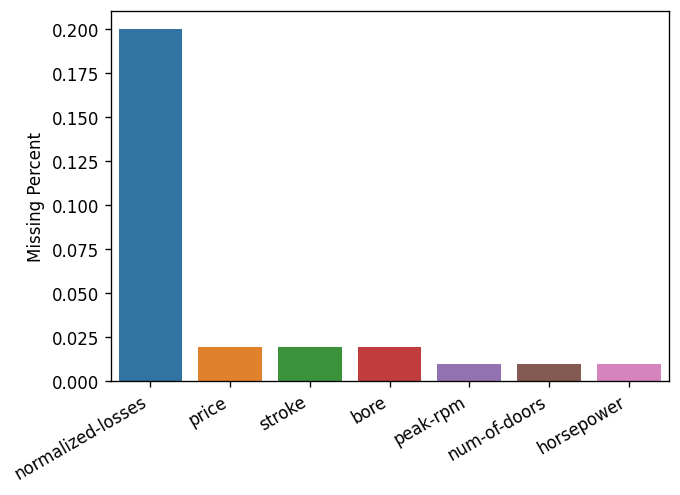

In [ ]:
plt.figure(figsize=(6,4))

missing_plot = sns.barplot(x = missing_table.index
                           , y = missing_table['Missing Percent'])

missing_plot.set_xticklabels(missing_plot.get_xticklabels()
                             , rotation = 30
                             , ha = 'right')

It is recognized that there are 7 columns that have missing values and the percentage of missing values is quite low (less than 20%). Therefore, the missing figures will then be filled through imputation. The multivariate imputation will be deployed for numeric data and most frequent naive imputation for categorical values.

In [ ]:
df_imputed[df.select_dtypes(include='object').columns]

print(type(df_imputed[df.select_dtypes(include='object').columns]))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
simple_imp = SimpleImputer(strategy='most_frequent')
iterative_imp = IterativeImputer(random_state=0)

df_imputed = df.copy()

df_imputed[df.select_dtypes(include='object').columns] = simple_imp.fit_transform(df_imputed[df.select_dtypes(include='object').columns])
df_imputed[df.select_dtypes(include=np.number).columns] = iterative_imp.fit_transform(df_imputed[df.select_dtypes(include=np.number).columns])

df_imputed.isna().sum().sum() # number of missing values

0

**ANALYZE TARGET VARIABLE (SALEPRICE)**

In [ ]:
df_imputed['price'].describe()

count      205.000000
mean     13250.202881
std       8013.459973
min       5118.000000
25%       7775.000000
50%      10295.000000
75%      16503.000000
max      45400.000000
Name: price, dtype: float64

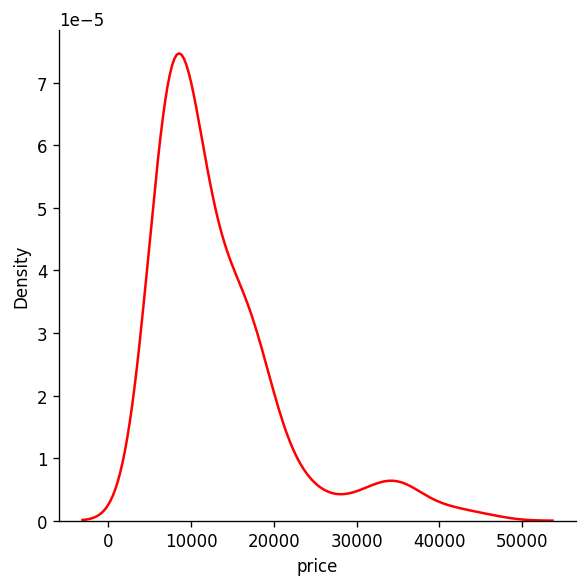

In [ ]:
sns.displot(df['price'], color='r', kind='kde')

The distribution is not symmetrical and is more right-skewed. This would result in some models, such as regression-based model, being less likely to predict the price successfully. One way to overcome this is by transforming the data.

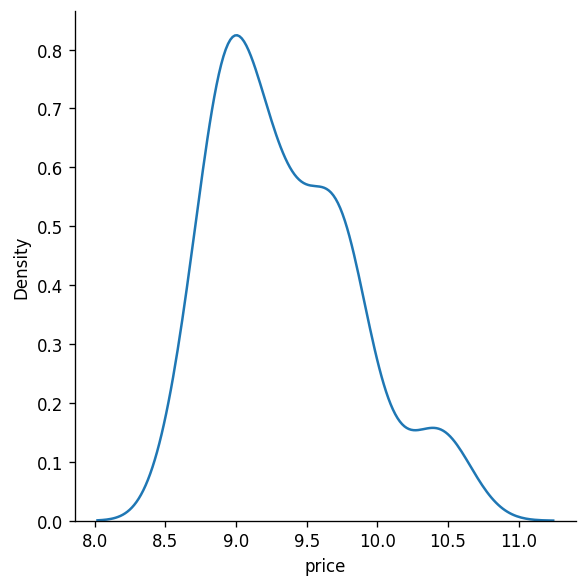

In [ ]:
# tranform data using log-transformation
log_transform = np.log(df['price'])
sns.displot(log_transform, kind='kde')

**CORRELATION MATRIX**

<ipython-input-70-a7b8f90e48ee>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat = df_imputed.corr()


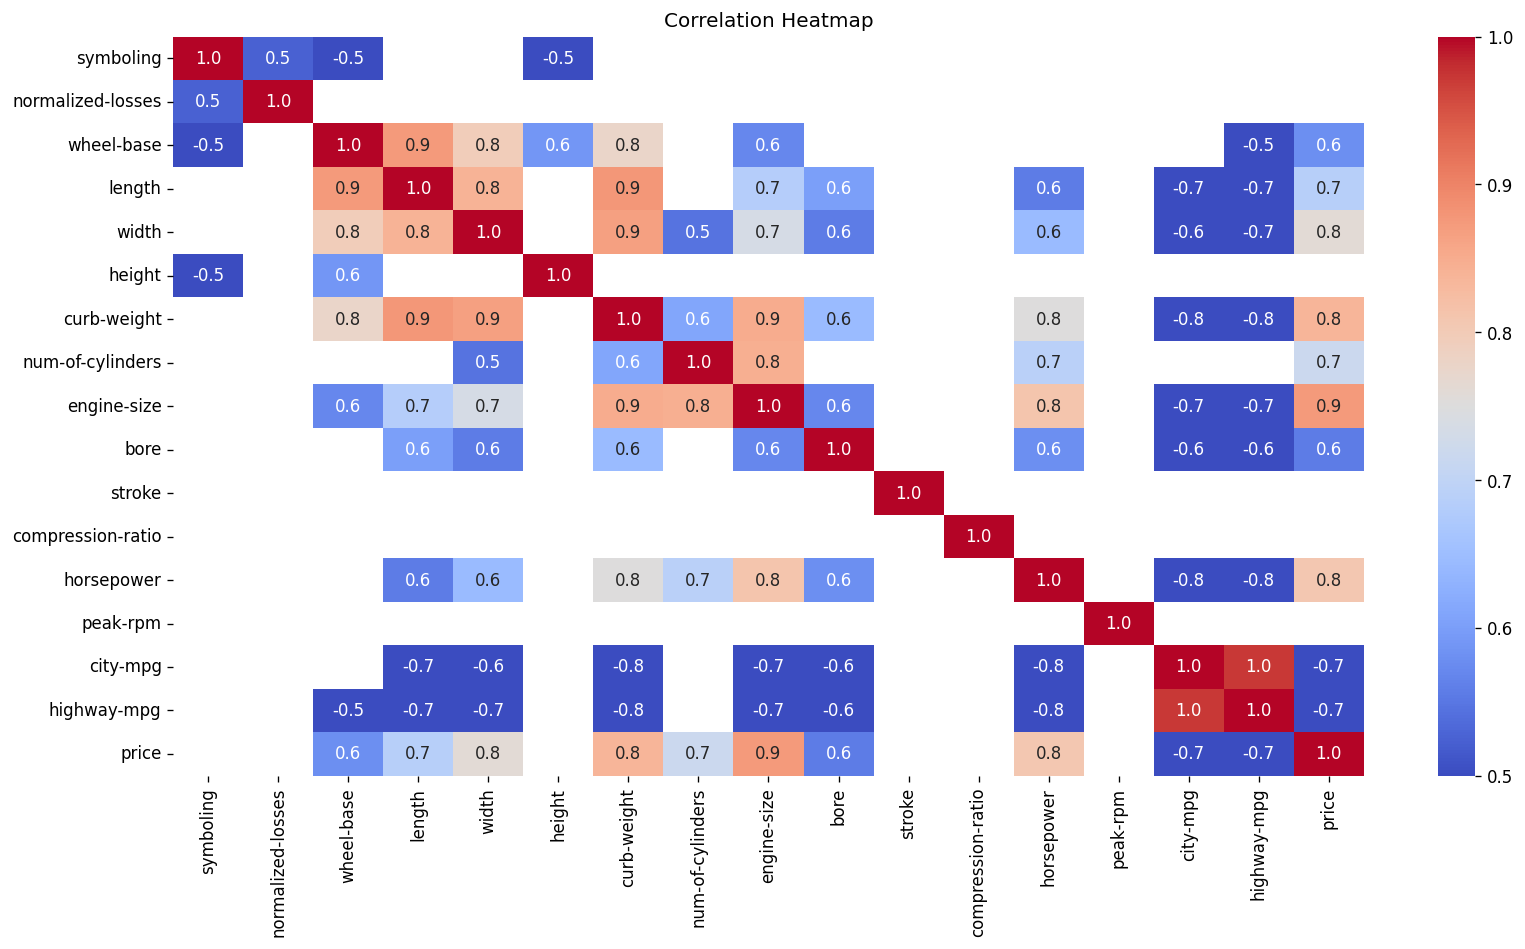

In [ ]:
corr_mat = df_imputed.corr()
corr_mat = corr_mat[abs(corr_mat) >= 0.5] # select correlations greater than 0.5

# plot correlation heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(corr_mat
            , annot=True
            , fmt='.1f'
            , cmap='coolwarm'
            , vmin=0.5
            , vmax=1)
title = plt.title('Correlation Heatmap')

Index(['price', 'engine-size', 'curb-weight', 'horsepower', 'width',
       'num-of-cylinders', 'length', 'wheel-base', 'bore', 'city-mpg'],
      dtype='object')


<Axes: >

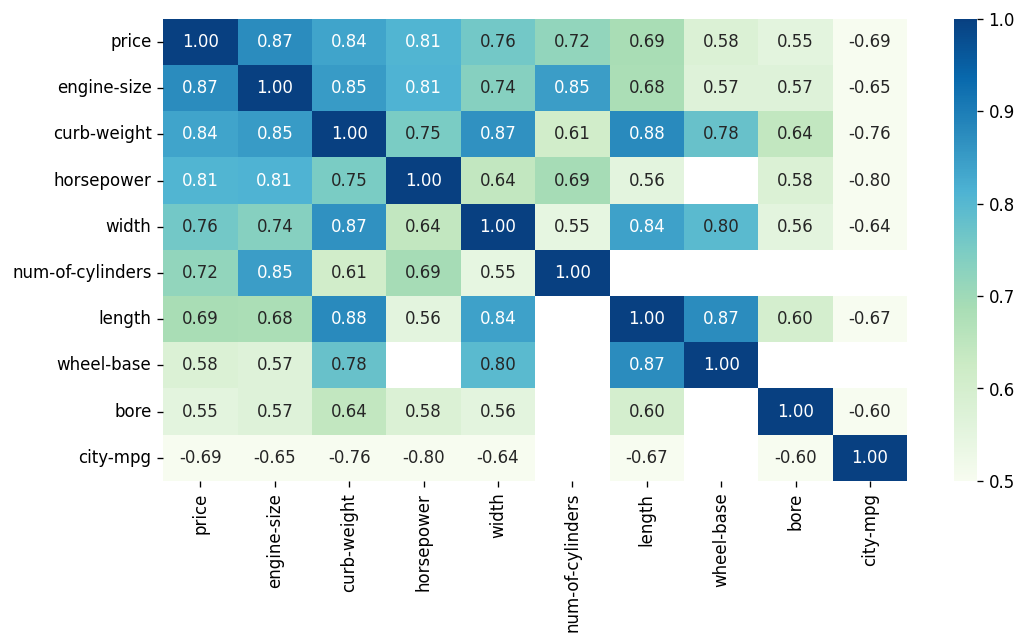

In [ ]:
# draw the heatmap with values are greater than or equal 0.5
cols = corr_mat.nlargest(10,'price').index
print(cols)
corr_map = df_imputed[cols].corr()

corr_map=corr_map[abs(corr_map) >= 0.5] #highlighting cell with higher than .5 correlation

plt.figure(figsize=(10,5))
sns.heatmap(corr_map
            , annot=True
            , fmt='.2f'
            , cmap='GnBu'
            , vmin=0.5
            , vmax=1)

**IMPLEMENTING MODEL**

Ater processing missing values and exploring the relationship between features and target variables, BaggingRegressor will be used to build the model to predict the price of used car. The model will be evaluated using coefficient of determination and root-mean-squared-error (rmse). These are the steps will be deployed:
*   Label Encoding for categorical columns
*   Set model parameters
*   Evaluate the prediction





In [ ]:
# list of categorical columns
encode_cols = ['make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 'drive-wheels', 'engine-location', 'engine-type', 'fuel-system']

for col in encode_cols:
  df_imputed[col] = LabelEncoder().fit_transform(df_imputed[col])

In [ ]:
# get data from the dataframe and split into train/test dataset
y = df_imputed['price'].values
X = df_imputed[['engine-size', 'curb-weight', 'horsepower', 'width', 'num-of-cylinders', 'length', 'wheel-base', 'bore', 'city-mpg']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# training model
model = BaggingRegressor(estimator=XGBRegressor())
model.fit(X_train, y_train)


# predict the output on the test dataset
y_pred = model.predict(X_test)


# printing the mean squared error between real value and predicted value and coefficient of determination
print('Root mean squared error: {:.2f}'.format(mean_squared_error(y_test, y_pred)**1/2))
print('Coefficient of determination: {:.2f}'.format(r2_score(y_test, y_pred)))

Root mean squared error: 2494415.51
Coefficient of determination: 0.93
